In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from grid_cells import GridCells
from utils import get_coords, to_tensor, get_loc_batch
from agent import Agent
from tqdm import tqdm

In [2]:
def eval_position(agent, size=4096):
    losses = list()
    for _ in range(size // 256):
        x, y = get_loc_batch(c, gc, bs=256)
        x = agent.actor(x)[1]
        loss = torch.sum((x - y)**2).detach().cpu().numpy()
        losses.append(loss)
    return np.mean(losses)

In [3]:
resolution = 400
MIN, MAX = -1, 1
N = 25
scales = np.linspace(150, 300, 30, dtype=int)

coords = get_coords(resolution, MIN, MAX)
gcs = GridCells(scales, n_per_module=N, res=resolution)
gcs.reset_modules(1)
gcs.compile_numpy()
grid_cells = gcs.grid_cells.transpose(1, 2, 0)
c, gc = to_tensor(coords), to_tensor(grid_cells)

hidden = 100
agent = Agent(grid_cells.shape[-1], 2, actor_hidden=hidden, lr_a=1e-4)
net = agent.actor
optim = agent.optim_actor

In [4]:
losses = list()
for _ in tqdm(range(10000)):
    optim.zero_grad()
    x, y = get_loc_batch(c, gc, bs=256)
    loss = torch.sum((net(x)[1] - y)**2, dim=-1).mean()
    loss.backward()
    optim.step()
    losses.append(loss.detach().cpu().item())

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:34<00:00, 46.71it/s]


Position loss: 0.243


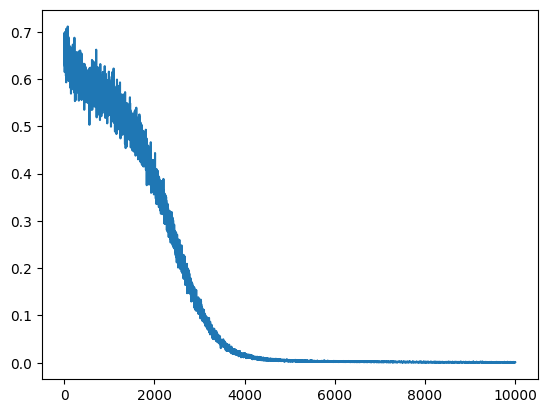

In [5]:
print(f"Position loss: {eval_position(agent):.03f}")
plt.plot(losses)
plt.show()

In [7]:
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:].numpy() + [[0], [hidden]]
print(net.lin2.weight[2:].detach().cpu().flatten()[idx.flatten()])

tensor([ 0.4349,  0.4371, -0.4373, -0.4470,  0.5015,  0.3952,  0.4145, -0.4207,
        -0.4223, -0.4252])


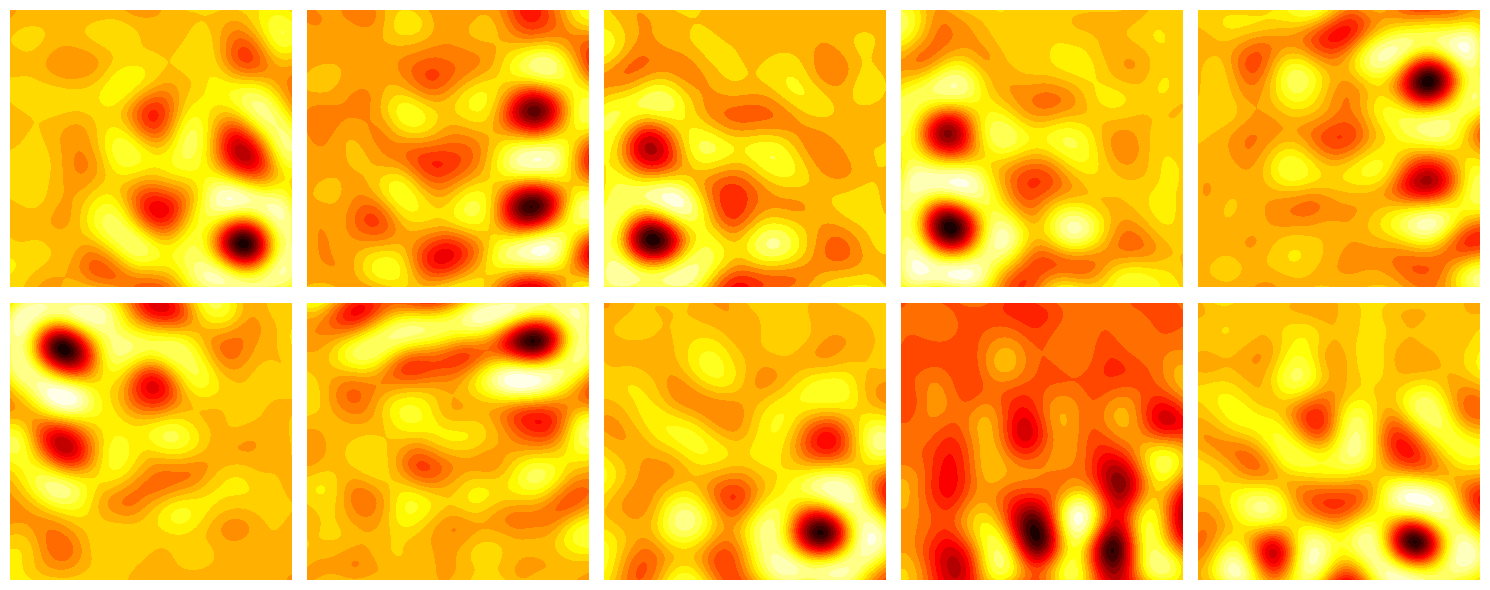

In [8]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

hidden = (gc @ net.lin1.weight.T).detach().cpu().numpy().transpose((-1, 0, 1))
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()